# **Signal Processing Project**

This work was prepared as a final project of a course I completed in the Weizmann Institute of Science during my PhD studies. Course name: "Practical Deep Learning for Science" by Prof. Eilam Gross

The main goal of the project was to demonstrate remote optical eavesdroping. For example, record a meeting which takes place in an isolated building by record the vibrations of the windows (or any other nearby object) and reconstruct the audio signal. 
There are numerous challeges in executing this goal:
* Audio frequencies varies between 20 Hz to 20,000 Hz that requires very Fast sampling rate  ( 20,000 Hz signal corresponds to sampling of 50μs) with "Tons" of data to record
* Probably low SNR (Signal to Noise ratio)
* An unknown transmission of the window and setup




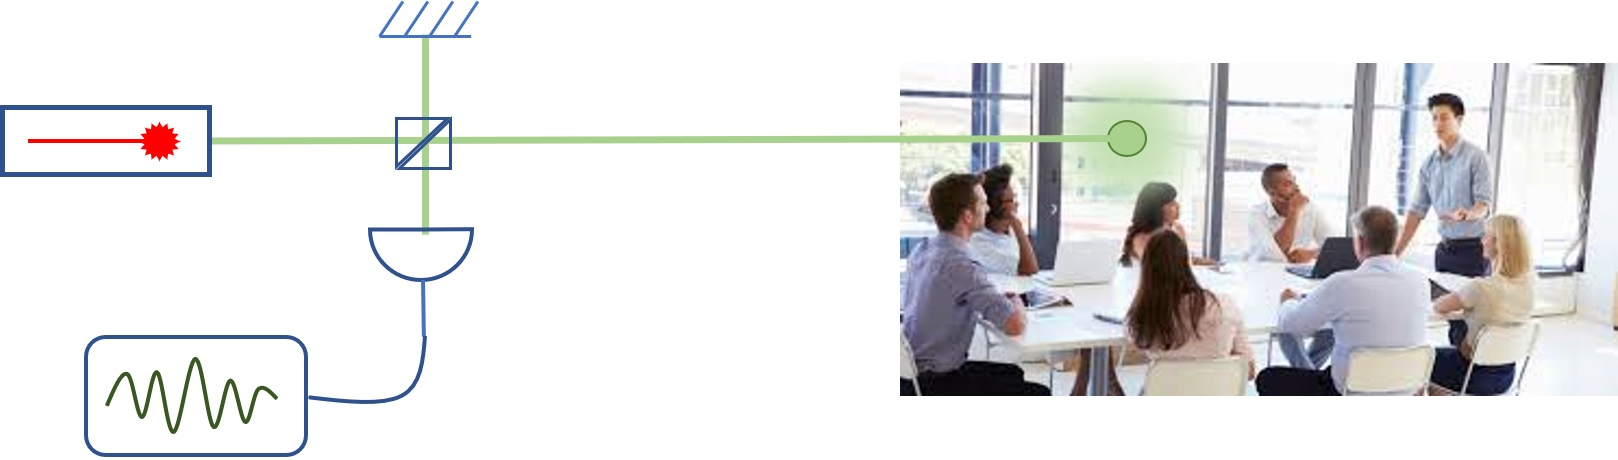

Sampling was carried out by an optical setup; a laser beam was reflected from a mirror that was attached to a speaker, the vibrations of the mirror served as the translation of the acoustic signal to an optical one. The optical signal was processed by a Lock-in amplifier which amplifies pre-defined frequencies with high SNR. As the the sampling rate was low (and shrunk even further while preprocessing the data) and the transmission function of the mirror was unknown, the audio was impossible to reconstruct in any analytical method.

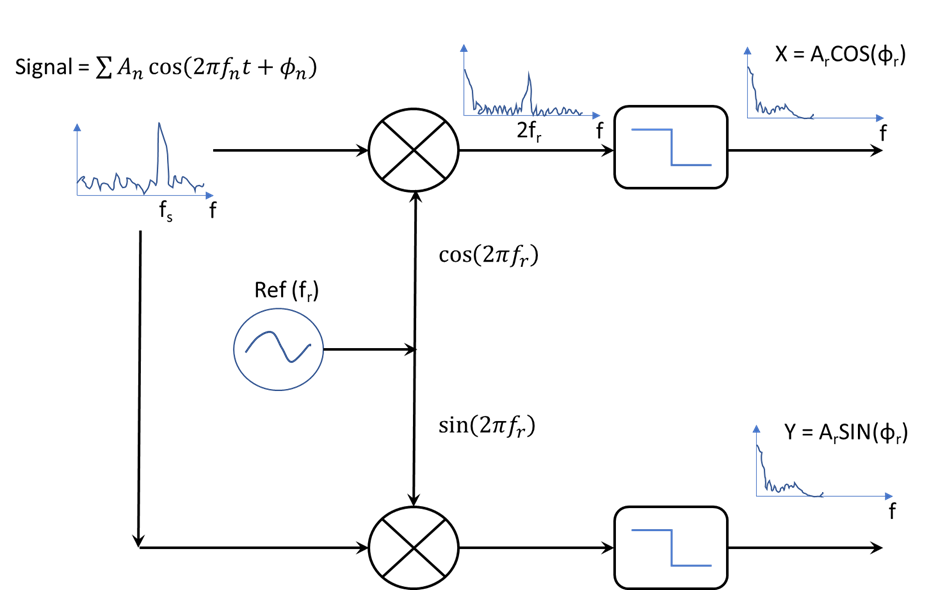


**The data:**\
The input data is given as scv files of four different audio inputs:
- Reconstruction noise
- Speach
- Electronic music
- Reggae music

10 frequencies with sine and cosine outputs (20 columns in total) was retrieved using the Lock-in amplifier for each class for a few minutes of sound. Due to the large volume of the data and the limited processing resources the Lock-in output was further reduced before used as an input for the current project.

**Training:**\
The training was performed on slices of sequenced data with the audio source as a target label. The model was prepared as a classification model for the sequenced data. Two approaches were examined:
1. RNN (lstm) - a natural choice for time-series data where the order of the data is meaningful
2. one-dimensional CNN - an adaptation of convolution that usualy used in 2D and 3D for image analysis to detect patterns in 1D  

# **Preprocessing**
In this stage the raw data will be imported and processed in following order:
1. Import the raw data (csv files) to a list of dataframes, each contains 42 features (Time, Complete Signal, 20 channels of frequencies) 
2. Reduce the number of features by using only the 10 cosine channels
3. Create a single dataset with random sequences as a single column with 20 arrays (input) and the files labels as target.
4. Split the data to training/validation/test sets

The final form of the dataset will be further used as a dataloader where torch.stack method is used to expand the dimension of the features to 20. The dataloaders will feed the NN for training in both models

## **Import Libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

## **Import Data**

In [0]:
from google.colab import files
files.upload()

Saving Construction.csv to Construction.csv
Saving Electronic.csv to Electronic.csv
Saving Reggae.csv to Reggae.csv
Saving Speach.csv to Speach.csv


In [40]:
!ls -a 

.   CNN.pt   Construction.csv  Reggae.csv  sample_data
..  .config  Electronic.csv    RNN.pt	   Speach.csv


In [0]:
# Create features-names list
N_col=42
col = [None]*N_col
features = [None]*int((N_col-2)/2)
col[0] = 'Time'
col[1] = 'Complete Signal'

for i in range(2,N_col,2):
  col[i] ='Cos_'+str(int(i/2))
  col[i+1]='Sin_'+str(int(i/2))
  features[int(i/2)-1] = 'Cos_'+str(int(i/2))

In [0]:
# Make class-dictionary
class_names ={   
   0 : 'Speach',
   1 : 'Construction',
   2 : 'Reggae',
   3 : 'Electronic'
}
n_classes = len(class_names)
class_names.keys(), class_names.items()

(dict_keys([0, 1, 2, 3]),
 dict_items([(0, 'Speach'), (1, 'Construction'), (2, 'Reggae'), (3, 'Electronic')]))

In [0]:
# Create a list of all csv files as data-frames
csv_list=[]
for i in range(n_classes):
  file_name = class_names[i]+'.csv'
  file_temp = pd.read_csv(file_name,header = None)
  file_temp.columns = col
  csv_list.append(file_temp)

In [0]:
#new csv list (ncl) with the columns specified in features list
ncl=[]
for c in csv_list:
  c1 = c[features]
  ncl.append(c1)

## **Raw data visualization**

In [0]:
ncl[0].head()

,Cos_1,Cos_2,Cos_3,Cos_4,Cos_5,Cos_6,Cos_7,Cos_8,Cos_9,Cos_10,Cos_11,Cos_12,Cos_13,Cos_14,Cos_15,Cos_16,Cos_17,Cos_18,Cos_19,Cos_20
0,5.0058,-77.208,39.960,-114.340,-81.571,-92.466,-215.42,101.91,3.4862,-82.662,-115.220,-61.760,-35.093,-50.751,-15.0400,-4.9374,7.58870,-53.664,24.711,-9.1144
1,4.9112,-28.703,21.611,-81.801,-52.674,-156.710,-191.23,125.16,28.8930,-72.475,-101.380,-73.321,-41.618,-60.286,-15.3190,-10.0720,7.39690,-18.369,31.084,-14.5830
2,35.6360,13.333,-16.989,-77.583,22.767,-226.270,-189.83,170.40,-2.8101,-80.514,-97.184,-71.407,-43.183,-52.982,-20.4700,-8.5843,8.31410,-59.162,25.920,-11.2690
3,52.6000,-52.854,-27.568,-110.160,-49.096,-229.830,-211.31,152.39,31.1940,-73.411,-75.561,-75.132,-25.334,-53.215,-6.2529,-8.5580,-0.69445,-49.897,17.915,-4.5869
4,-12.1250,-12.702,-65.392,-25.738,-11.680,-247.450,-167.21,160.26,5.1365,-54.274,-84.678,-114.820,-30.748,-33.920,-22.3520,-13.5490,-6.39280,-26.364,16.082,-12.0560


In [0]:
list(class_names.values())

['Speach', 'Construction', 'Reggae', 'Electronic']

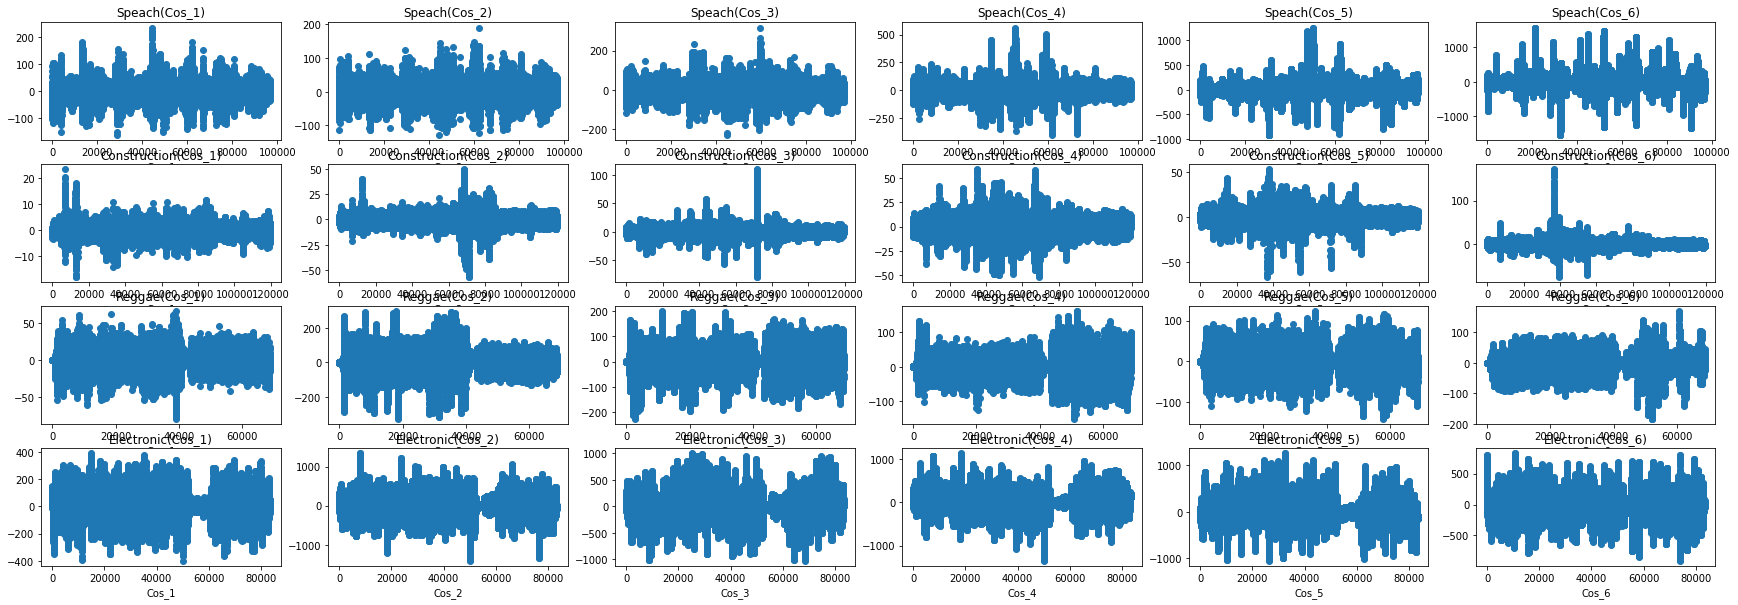

In [0]:
X_view = 6
variables = features[:X_view]

#mean_and_std = {}
fig, ax = plt.subplots(n_classes,X_view,figsize=(30,10))
L=len(ncl[0])

file_index = 0
for axlist in ax:
  varindex = -1
  df=ncl[file_index]
  L=len(df)
  for ax_i in axlist:
        varindex+=1
        varname = variables[varindex]
        p =ax_i.scatter(range(L),df[varname])
        #mean_and_std[varname] = [np.mean(train_df[varname]),np.std(train_df[varname])]
        #ax_i.legend()
        ax_i.set_title(class_names[file_index]+'('+varname+')')
        ax_i.set_xlabel(varname)
  file_index+=1
plt.show()

## **Arrange as a dataset**

In [0]:
#hyperparameters

seq_length = 1500
seq_num = 1000
bs = 25 #batchsize
num_workers = 1
input_channels = 1
lr0 = 0.005
m = len(features)
MSE = False # Cross-entropy loss
hss = 50 #hidden state size

In [0]:
def collect_sequence(df, target):
  
    target_vec = [target]
    n_entries = len(df)
    
    start_idx = np.random.randint(0,n_entries-seq_length-1)
    seq = df.iloc[start_idx:start_idx+seq_length].values  
    df_i = pd.DataFrame.from_dict({'input': [seq], 'target': [target_vec]})
    
    return df_i   

In [0]:
# Run collect sequence on the entire data
dt_list = []
for c in class_names:
  dt = pd.concat([collect_sequence(ncl[c], c) for _ in range(seq_num)], ignore_index=True)
  dt_list.append(dt)

In [0]:
def arrange_dataset(raw_list, n_train, n_val):
  data = pd.concat(raw_list, ignore_index=True)
  #shuffle samples and creating train_set and test_set
  data = data.sample(frac=1).reset_index(drop=True)
  cutoff1 = round(len(data)*n_train)
  cutoff2 = round(len(data)*(n_train+n_val))
  train = data[:cutoff1]
  val = data[cutoff1:cutoff2]
  test = data[cutoff2:]
  return train,val,test

train_df, val_df, test_df = arrange_dataset(dt_list, 0.8,0.1)
len(train_df), len(val_df), len(test_df)

(3200, 400, 400)

In [0]:
train_df.head(10)

,input,target
0,"[[-12.069, 23.398000000000003, -15.228, -32.09...",[0]
1,"[[-0.55974, 0.78162, 2.6151, 3.8049, -2.4508, ...",[0]
2,"[[0.19251, -4.6285, 5.7693, -0.467319999999999...",[1]
3,"[[-10.532, -85.85700000000001, 7.0163, -23.726...",[2]
4,"[[-6.1812, 27.049, 36.23, -10.634, -20.566, -1...",[2]
5,"[[0.007875700000000001, -1.2196, -6.6249, 10.2...",[0]
6,"[[0.011692000000000001, 0.00077953, 0.00135529...",[2]
7,"[[15.024000000000001, -8.6977, -62.728, 11.829...",[3]
8,"[[0.48189, -3.7787, 3.3258, -1.955, 1.8519, -0...",[1]
9,"[[4.7088, 18.432000000000002, -38.721, 40.68, ...",[2]


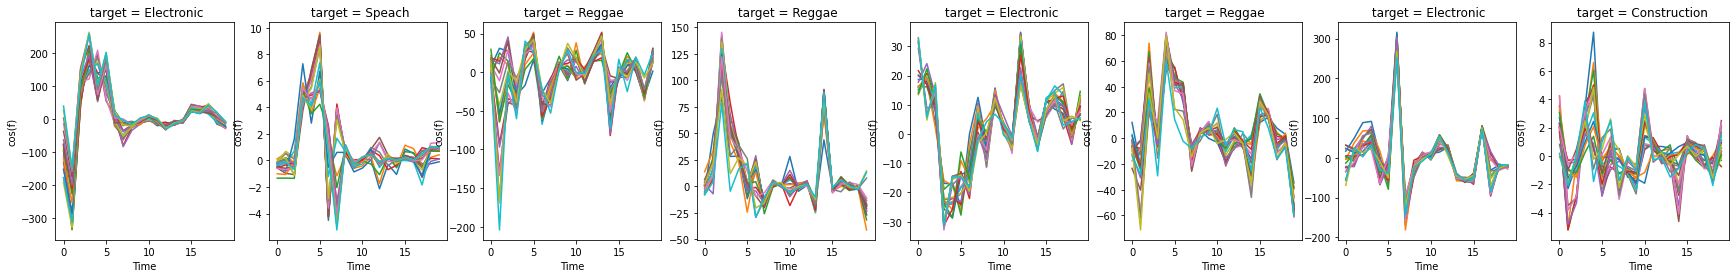

In [0]:
# Display examples from final dataset

fig, ax = plt.subplots(1,8,figsize=(30,4))
for ax_i in ax:
  r=np.random.randint(0,len(train_df))
  for i in range(len(features)):
    p = train_df.input[r][i]
    ax_i.plot(p)
    
  tr = train_df.target[r][0]
  ax_i.set_title(' target = '+class_names[tr])
  ax_i.set_ylabel('cos(f)')
  ax_i.set_xlabel('Time')
plt.show()

# **RNN**
The data is processed via a dataloader into an lstm net. After a final-hidden state the weights are running through a fully connected net (FCN) to a final classification layer. ReLU activation is used for non-linear fitting and dropout is used to avoid overfitting to the training data. The validation loss is compared to the training loss for learning-rate tuning. Final evaluation of the model is performed on the test-set.

**training**:
 
The model is built using Pytorch library and the training is performed using a nested loop of epochs (outer-loop) and data-loaders (inner-loop). In each epoch the Adam optimser perform a step according to the current loss function of the training set. To monitor the state of overfitting/underfitting, a second data-loader of the validation set is running in each epoch as well (in evaluation mode). The validation loss is also used to save the model whenever there is a minima of the loss to save the model before diverging.

##Creating a dataloader

In [0]:
# Dataset object 
class MyCustomDataset(Dataset):

    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # features of the df
        sample_df = self.df.iloc[idx]
        sample = {
            'input': sample_df['input'],
            'target': sample_df['target'],
        }
        return sample

rnn_train_set = MyCustomDataset(train_df)
rnn_val_set = MyCustomDataset(val_df)
rnn_test_set = MyCustomDataset(test_df)

rnn_train_set[:5]

{'input': 0    [[-12.069, 23.398000000000003, -15.228, -32.09...
 1    [[-0.55974, 0.78162, 2.6151, 3.8049, -2.4508, ...
 2    [[0.19251, -4.6285, 5.7693, -0.467319999999999...
 3    [[-10.532, -85.85700000000001, 7.0163, -23.726...
 4    [[-6.1812, 27.049, 36.23, -10.634, -20.566, -1...
 Name: input, dtype: object, 'target': 0    [0]
 1    [0]
 2    [1]
 3    [2]
 4    [2]
 Name: target, dtype: object}

In [0]:
def rnn_collate(batch):
    
    vol_seq = [ torch.FloatTensor(sample['input']) for sample in batch]
    targets = [ torch.LongTensor(sample['target']) for sample in batch]
          
    input_tensor = torch.stack(vol_seq)
    targets_tensor = torch.stack(targets)
                      
    return input_tensor, targets_tensor

In [0]:
rnn_train_loader = torch.utils.data.DataLoader(rnn_train_set,
                                             batch_size=bs, shuffle=True,collate_fn=rnn_collate,
                                             num_workers=num_workers)

rnn_val_loader = torch.utils.data.DataLoader(rnn_val_set,
                                             batch_size=bs, shuffle=True,collate_fn=rnn_collate,
                                             num_workers=num_workers)

In [0]:
def print_n_iterations(train_loader, n):
  i=0
  for x,y in train_loader:
      i+=1 
      print('---iteration no.',i,'----')
      print("input dimension = ", x.shape)
      print("the dimension of the output (y) is: ", y.shape)
      if i==n:
        break

print_n_iterations(rnn_train_loader, 3)

---iteration no. 1 ----
input dimension =  torch.Size([25, 1500, 20])
the dimension of the output (y) is:  torch.Size([25, 1])
---iteration no. 2 ----
input dimension =  torch.Size([25, 1500, 20])
the dimension of the output (y) is:  torch.Size([25, 1])
---iteration no. 3 ----
input dimension =  torch.Size([25, 1500, 20])
the dimension of the output (y) is:  torch.Size([25, 1])


## **RNN model & training**

In [0]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN,self).__init__()
    
    size_of_sequence_element = m #check if the input is a sequence
    self.hidden_state_size = hss
    self.num_layers = 1
    hidden_dim = n_classes*3
    
    self.lstm1 = nn.LSTM(size_of_sequence_element,self.hidden_state_size, batch_first = True, 
                        num_layers=self.num_layers)
    self.fc = nn.Linear(self.hidden_state_size,hidden_dim)
    self.activation1 = nn.ReLU(inplace=True)
    self.classify = nn.Linear(hidden_dim, n_classes)
    
  def forward(self,x,outputsize = n_classes):
    
    hidden_states, (final_hidden_state, cell_state) = self.lstm1(x)
    
    out = self.fc(final_hidden_state) #[20,1,2]
    out = self.activation1(out)
    out = F.dropout(out, p=0.5, training=self.training)
    
    out = self.classify(out)
    out = out.permute(1,2,0)

    return out
    
rnn = RNN()

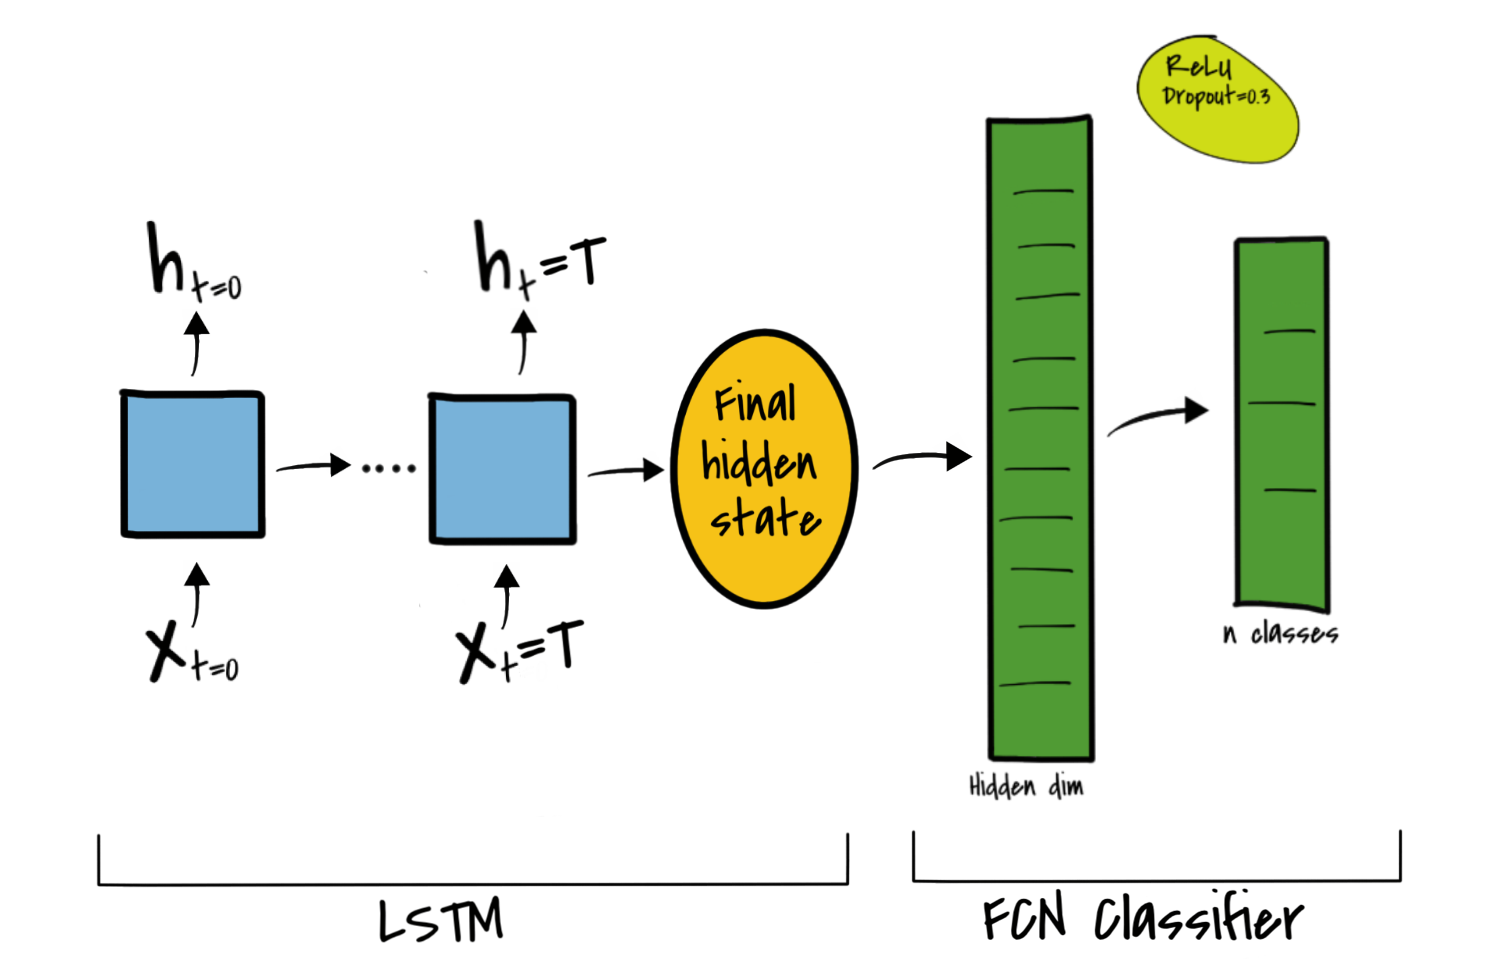

In [0]:
def run_n_epochs(model, optimiser, train_loader, val_loader, epochs, lr_min=0.01):
  loss_list=[]
  v_loss_list=[]
  model_name = str(type(model)).split('.', 1)[1][:3]+ '.pt'
  lr = optimiser.param_groups[0].get('lr')

  for j in range(epochs):
    # Training Loop
    model.train()
    arr=[]
    for x,y in train_loader:
      optimiser.zero_grad()
      outputs = model(x)
      loss = loss_func(outputs,y)      
      arr.append(loss.detach().numpy())
      loss.backward()
      optimiser.step()
    t_loss = np.mean(arr)

    # Validation Loop  
    model.eval()
    arr=[]
    for x, y in val_loader:
      outputs = model(x)
      temp_loss = loss_func(outputs, y)
      arr.append(temp_loss.detach().numpy())
    v_loss = np.mean(arr)

    # Print status and save model
    print("Epoch #",j+1,"(lr=",round(lr,5),") , training-loss :",t_loss, " , validation-loss :",v_loss)
    if len(v_loss_list)>0 and v_loss<min(v_loss_list):
      print('New minimal validation loss, saving model: ' + model_name)
      torch.save(model.state_dict(), model_name)
    
    # Update Values
    loss_list.append(t_loss)
    v_loss_list.append(v_loss)
    if (np.mod(j,2)==0) and lr>lr_min:
      lr = lr*0.4 
      optimiser = torch.optim.Adam(rnn.parameters(),lr=lr)
    
  return loss_list, v_loss_list

In [0]:
loss_func = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(rnn.parameters(),lr=lr0)

rnn_loss, rnn_val_loss = run_n_epochs(rnn,optimiser, rnn_train_loader, rnn_val_loader, 10, lr_min=0.001)

Epoch # 1 (lr= 0.005 ) , training-loss : 1.1384412  , validation-loss : 0.7582084
Epoch # 2 (lr= 0.002 ) , training-loss : 0.76848406  , validation-loss : 0.6547856
New minimal validation loss, saving model: RNN.pt
Epoch # 3 (lr= 0.002 ) , training-loss : 0.6484163  , validation-loss : 0.6263033
New minimal validation loss, saving model: RNN.pt
Epoch # 4 (lr= 0.0008 ) , training-loss : 0.5745557  , validation-loss : 0.61616296
New minimal validation loss, saving model: RNN.pt
Epoch # 5 (lr= 0.0008 ) , training-loss : 0.52428484  , validation-loss : 0.62118936
Epoch # 6 (lr= 0.0008 ) , training-loss : 0.49583083  , validation-loss : 0.6010328
New minimal validation loss, saving model: RNN.pt
Epoch # 7 (lr= 0.0008 ) , training-loss : 0.46270308  , validation-loss : 0.5902432
New minimal validation loss, saving model: RNN.pt
Epoch # 8 (lr= 0.0008 ) , training-loss : 0.42672813  , validation-loss : 0.61009014
Epoch # 9 (lr= 0.0008 ) , training-loss : 0.40945926  , validation-loss : 0.60229

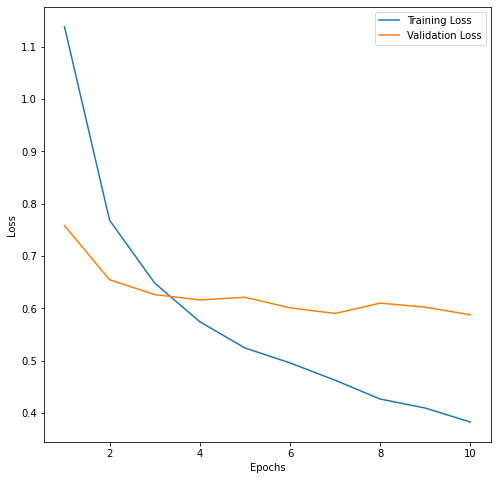

In [0]:
def show_loss(loss, v_loss):
  fig,ax = plt.subplots(figsize=(8,8))
  ax.plot(np.arange(len(loss))+1,loss, label='Training Loss')
  ax.plot(np.arange(len(v_loss))+1,v_loss,  label='Validation Loss')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.legend()
  plt.show()

show_loss(rnn_loss, rnn_val_loss)

## **RNN training Evaluation**

In [0]:
# Create a test-loader to evaluate the model 
rnn.load_state_dict(torch.load('RNN.pt'))
rnn.eval()

#test_ind = np.random.randint(len(test_df))
dataset_test = MyCustomDataset(test_df)

rnn_test_loader = torch.utils.data.DataLoader(dataset_test,
                                             batch_size=1, shuffle=False,collate_fn=rnn_collate,
                                             num_workers=1)

In [0]:
def create_eval_df(test_loader, model):
  col = ['Input','Prediction','Decision','Target']
  eval_df = pd.DataFrame(columns = col)
  num_pred = 1
  i=0

  for x,y in test_loader:
    if type(model)==RNN:
      predicted = model(x, num_pred)
    else:
      predicted = model(x)
    # set values for a dataframe
    input1 = x.transpose(2,1)[0][0].numpy()
    prediction1 = predicted.transpose(2,1)[0][0].detach().numpy()
    target1 = y.numpy().item()
    decision1 = np.argmax(prediction1)
    eval_df.loc[i] = [input1,prediction1,class_names[decision1],class_names[target1]]
    i+=1
  return eval_df

rnn_df = create_eval_df(rnn_test_loader,rnn)
rnn_df.head(20)

,Input,Prediction,Decision,Target
0,"[-0.94622, 0.97079, -0.67907, -0.30254, -0.082...","[-1.0410157, 2.32971, 0.43611747, -3.3633642]",Construction,Construction
1,"[-70.244, -80.017, -69.278, -59.082, -51.321, ...","[-1.2070509, -6.572962, -0.67855954, 2.209423]",Electronic,Electronic
2,"[-3.1316, -0.67888, 0.76473, 0.29264, -0.91625...","[-2.2841277, 3.4733627, 0.69858134, -4.850827]",Construction,Construction
3,"[54.501, 51.381, 49.939, 51.886, 47.869, 39.83...","[-3.7569938, -12.592636, -0.82174426, 4.543914]",Electronic,Electronic
4,"[-0.38918, 0.36262, 1.7335, 0.52969, -0.33141,...","[-1.5915797, 3.0940924, 0.58225787, -4.426888]",Construction,Construction
5,"[-10.532, -2.5737, 8.0481, -4.3315, 10.601, -0...","[-4.355558, -2.3546598, 1.979269, -0.07939741]",Reggae,Reggae
6,"[-11.835, 3.5394, 5.0104, 5.0524, 1.983, -3.92...","[-3.0232062, -0.07296854, 0.98239815, -0.8646185]",Reggae,Reggae
7,"[2.0343, 7.7334, -5.108, 0.91001, 8.137, -17.9...","[-9.573461, -6.803853, 4.398612, 1.6625726]",Reggae,Reggae
8,"[-0.29323, -0.10064, -0.20329, -0.8056, -0.754...","[-1.946462, 3.2504795, 0.641621, -4.602405]",Construction,Construction
9,"[-3.384, -8.2307, -19.796, -16.885, -18.823, -...","[1.8606459, -7.35809, -3.4032717, 2.047369]",Electronic,Electronic


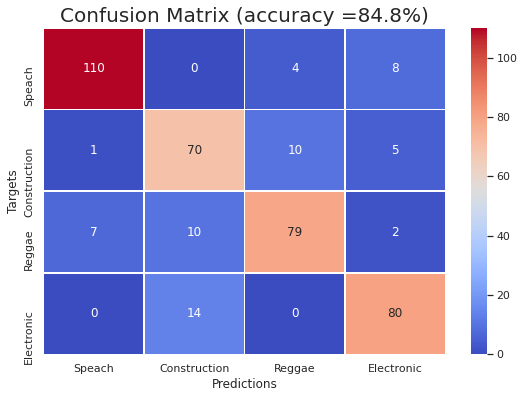

In [0]:
def show_accuracy(eval_df):
  predictions = eval_df.Decision.values
  targets = eval_df.Target.values
  conf_matrix = confusion_matrix(predictions, targets)
  Accuracy = sum(eval_df.Decision == eval_df.Target)/len(eval_df)
  #Draw a heatmap with the numeric values in each cell  
  sns.set()
  f, ax = plt.subplots(figsize=(9, 6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, xticklabels= list(class_names.values()) , yticklabels= list(class_names.values()), cmap = "coolwarm")
  title = "Confusion Matrix (accuracy ={}%)".format(round(Accuracy*100,1))
  ax.set_title(title, fontsize=20)
  ax.set(xlabel='Predictions', ylabel='Targets')
  plt.show()

show_accuracy(rnn_df)

# **1D CNN**

## Preparing the data for 1D CNN
For a second model 1D CNN was chosen to detect patterns efficiently, the training procedure and evaluation will be performed very similiarly to the lstm model on the same data. However, note a few changes due to the shorter running time of the model; (1) for the CNN I used longer sequence lengths and (2) more epochs are running in the training loop. Additionally, due to the difference in the model dimensions I used a new collate function for the data-loader.

In [0]:
def cnn_collate(batch):
    vol_seq = [ torch.FloatTensor(sample['input']) for sample in batch]
    targets = [ torch.LongTensor(sample['target']) for sample in batch]
    
    input_tensor=torch.stack(vol_seq)
    input_tensor=input_tensor.permute(0,2,1)
    targets_tensor=torch.stack(targets)
    
    return input_tensor,targets_tensor

In [0]:
seq_length = 3000
seq_num = 500

dt_list_cnn = []
for c in class_names:
  dt = pd.concat([collect_sequence(ncl[c], c) for _ in range(seq_num)], ignore_index=True)
  dt_list_cnn.append(dt)

train_cnn, val_cnn, test_cnn = arrange_dataset(dt_list_cnn, 0.8,0.1)
train_set = MyCustomDataset(train_cnn)
valid_set = MyCustomDataset(val_cnn)
test_set = MyCustomDataset(test_cnn)

#Creating dataloaders
cnn_train_loader=torch.utils.data.DataLoader(train_set,batch_size=50,shuffle=True,collate_fn=cnn_collate,num_workers=1)
cnn_val_loader=torch.utils.data.DataLoader(valid_set,batch_size=50,shuffle=True,collate_fn=cnn_collate,num_workers=1)

print_n_iterations(cnn_train_loader, 2)

---iteration no. 1 ----
input dimension =  torch.Size([50, 20, 3000])
the dimension of the output (y) is:  torch.Size([50, 1])
---iteration no. 2 ----
input dimension =  torch.Size([50, 20, 3000])
the dimension of the output (y) is:  torch.Size([50, 1])


## **CNN Model & Training**

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=20, out_channels=16,kernel_size=5, stride=1, padding=0,),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=4),   
        )
        self.conv2 = nn.Sequential(         
            nn.Conv1d(in_channels=16,out_channels=1,kernel_size=5,stride=1,padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=4),    
            
        )
        self.Linear = nn.Sequential(nn.Linear(186,200),nn.Dropout(0.5), nn.Linear(200, 80))
        self.out=  nn.Linear(80,4)
             
        #self.out2=  nn.Linear(2,2)
    def forward(self,x):
        #print('in:',x.size())
        x = self.conv1(x)
        #print('1:',x.size())
        x = self.conv2(x)
        #print('2:',x.size())
        x = self.Linear(x)
        x=self.out(x)
        #print('out:',x.size())
        x=x.permute(0,2,1)
        return x
cnn=CNN()

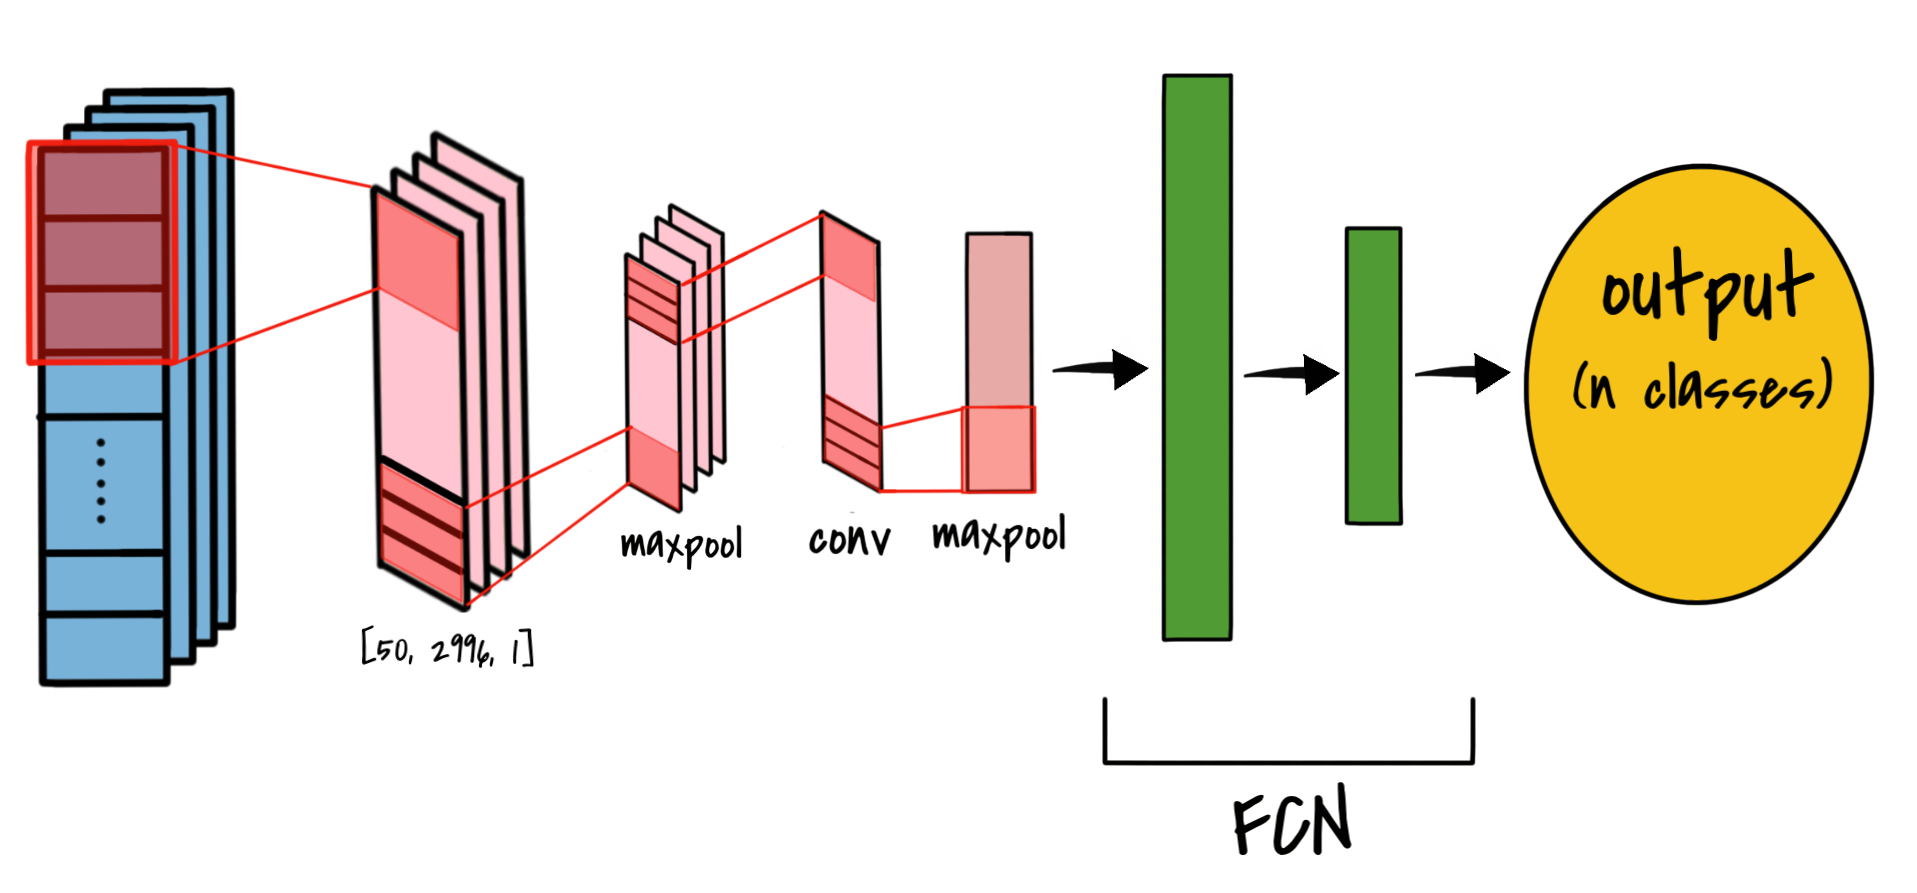


In [0]:
print("Model's state_dict:")
for param_tensor in cnn.state_dict():
    print(param_tensor, "\t", cnn.state_dict()[param_tensor].size())

Model's state_dict:
conv1.0.weight 	 torch.Size([16, 20, 5])
conv1.0.bias 	 torch.Size([16])
conv2.0.weight 	 torch.Size([1, 16, 5])
conv2.0.bias 	 torch.Size([1])
Linear.0.weight 	 torch.Size([200, 186])
Linear.0.bias 	 torch.Size([200])
Linear.2.weight 	 torch.Size([80, 200])
Linear.2.bias 	 torch.Size([80])
out.weight 	 torch.Size([4, 80])
out.bias 	 torch.Size([4])


In [0]:
loss_func = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),lr=0.001)
cnn_loss, cnn_val_loss = run_n_epochs(cnn,optimiser,cnn_train_loader,cnn_val_loader,25)

Epoch # 1 (lr= 0.001 ) , training-loss : 1.1849749  , validation-loss : 1.0069513
Epoch # 2 (lr= 0.001 ) , training-loss : 0.87232727  , validation-loss : 0.8242937
New minimal validation loss, saving model: CNN.pt
Epoch # 3 (lr= 0.001 ) , training-loss : 0.7011314  , validation-loss : 0.6643442
New minimal validation loss, saving model: CNN.pt
Epoch # 4 (lr= 0.001 ) , training-loss : 0.5733966  , validation-loss : 0.5690111
New minimal validation loss, saving model: CNN.pt
Epoch # 5 (lr= 0.001 ) , training-loss : 0.5003751  , validation-loss : 0.51907384
New minimal validation loss, saving model: CNN.pt
Epoch # 6 (lr= 0.001 ) , training-loss : 0.46063614  , validation-loss : 0.5271275
Epoch # 7 (lr= 0.001 ) , training-loss : 0.4342886  , validation-loss : 0.47138646
New minimal validation loss, saving model: CNN.pt
Epoch # 8 (lr= 0.001 ) , training-loss : 0.41013354  , validation-loss : 0.45146608
New minimal validation loss, saving model: CNN.pt
Epoch # 9 (lr= 0.001 ) , training-loss

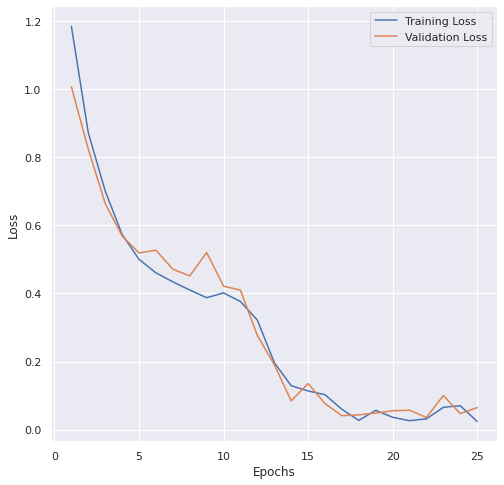

In [0]:
show_loss(cnn_loss, cnn_val_loss)

## **CNN Training Evaluation**

In [0]:
cnn.load_state_dict(torch.load('CNN.pt'))
cnn.eval()
cnn_test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=1, shuffle=False,collate_fn=cnn_collate,
                                        num_workers=1)

In [0]:
cnn_df = create_eval_df(cnn_test_loader,cnn)
cnn_df.head(20)

,Input,Prediction,Decision,Target
0,"[-11.642, -61.389, -4.7719, -1.7026, 13.465, 1...","[-31.763666, 3.062461, 12.863911, 6.469829]",Reggae,Reggae
1,"[-0.87081, -2.9819, -1.1533, 6.3409, -1.2579, ...","[-14.537503, 5.5569086, 7.6679735, -1.9166024]",Reggae,Reggae
2,"[23.093, 15.72, 16.612, -20.325, -66.351, -238...","[14.03197, 9.323599, -2.2002578, -14.106853]",Speach,Speach
3,"[0.76061, -1.1151, 8.1932, 0.092265, 2.0527, 0...","[0.92447734, 7.0257335, 2.0024712, -7.709439]",Construction,Construction
4,"[-11.387, -9.7686, -19.78, -57.589, 407.43, 62...","[14.461254, 9.390624, -2.3471498, -14.307512]",Speach,Speach
5,"[-51.313, -307.14, 101.97, -41.026, -44.053, 1...","[-552.7801, -61.800373, 189.79895, 230.52318]",Electronic,Electronic
6,"[10.409, -12.828, 24.137, 24.371, -58.645, 20....","[14.461254, 9.390624, -2.3471498, -14.307512]",Speach,Speach
7,"[3.3368, -198.93, 71.177, -84.256, -46.178, -2...","[-743.1434, -96.82811, 249.86404, 322.02197]",Electronic,Electronic
8,"[180.99, -423.16, 98.903, 236.77, 782.42, -341...","[-501.1405, -53.250927, 172.01518, 206.93741]",Electronic,Electronic
9,"[-12.723, -28.792, 15.147, -25.972, 12.92, 14....","[-36.234985, 1.471935, 14.249745, 8.986296]",Reggae,Reggae


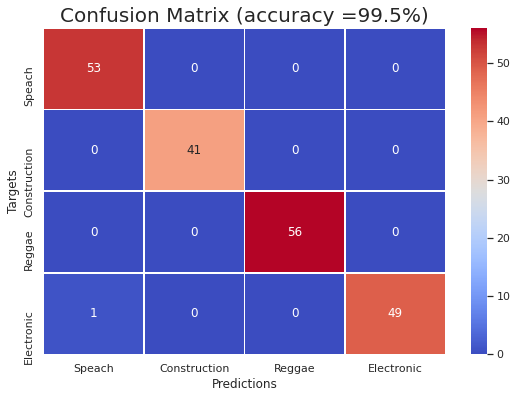

In [0]:
show_accuracy(cnn_df)

# **Conclusions**

Check which samples were misclassified

In [0]:
wrong = cnn_df.loc[cnn_df['Decision']!=cnn_df['Target'],:]
wrong

,Input,Prediction,Decision,Target
84,"[-0.26053, -5.4781, 2.9564, 16.456, -7.7289, -...","[8.592227, 8.318732, -0.48269418, -11.486961]",Speach,Construction


In [0]:
mcl_df = pd.DataFrame(columns= class_names.values()) 
for i in range(len(wrong)):
  mcl_df.loc[i] = wrong['Prediction'].iloc[i]

mcl_df

,Speach,Construction,Reggae,Electronic
0,8.592227,8.318732,-0.482694,-11.486961


## Summary
While tradional lstm neural-net exhibited reasonal accuracy, of approximately 85%, 1D CNN showed better results of approximately 99% (10 folds less errors) with much less running time and less optimizations. It is probable that regression problem that predicts the following siעnal would be more suitable to an RNN model but simple classifiaction between such distinct audio recordings requires only certein patterns which can be detected in 1D kernel of convolution. Due to limitations of running-time and CPU only a fraction of the data was used and due to the long process of collecting the data only few categories of sound were classified. However, the good results may hopefully imply that the information of the audio is recoverable from the optical signal despite the analytical diffuculties. 